<a href="https://colab.research.google.com/github/julia-e-ma/movies/blob/main/RandomMovieGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports and google drive authorization
from google.colab import auth
auth.authenticate_user()
import random
import pandas as pd
import gspread
from google.auth import default
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import matplotlib.pyplot as plt
import numpy as np
from google.colab import userdata
import urllib.request
import json
from datetime import date
creds, _ = default()
gc = gspread.authorize(creds)
api_key = userdata.get('watchmode_key')

This notebook is based off of the movie spreadsheet. The spreadsheet contains a list of movies we'd like to watch together. If you can't decide on a movie, you can use this notebook to select parameters (genre, runtime, preferred actors, etc.) to decide on a movie to watch.

Add google form integration so we can update movies when watched and movies when we find a new one we want to watch.

In [ ]:
#with urllib.request.urlopen('https://api.watchmode.com/v1/sources/?apiKey='+api_key) as url:
#      data = json.loads(url.read().decode())
#      print(data)

In [2]:
# list of streaming platforms we both have
streaming_platforms = {
    'Netflix':203,
    'Hulu':157,
    'Max':387,
    'Disney+':372,
    'Apple':371,
    'Prime':26,
    'Peacock Premium': 389
}

In [3]:
# read in the existing spreadsheet
doc = gc.open('mega movie list')
worksheet = doc.sheet1
rows = worksheet.get_all_values()
movies = pd.DataFrame.from_records(rows)
movies.columns = movies.iloc[0]
movies = movies.drop(movies.index[0])

In [4]:
# this function is used to generate a normalized IMDb rating within the genre cluster
# requested feature because horror movies are usually bad and this will show movie rating within its genre for better comparison
def normalize(x):
  return (x-x.min())/(x.max()-x.min())
movies['IMDb'] = pd.to_numeric(movies['IMDb'], errors='coerce')
movies['Normalized'] = movies.groupby('Genre Cluster').IMDb.transform(normalize)
movies.head()

,Movie,Primary Genre,Genre 2,Year,Runtime,Streaming,RT,IMDb,Noteworthy Actors,Notes,Category,Genre Cluster,Normalized,Watchmode ID
1,The Feels,Comedy,,2017,1h30m,Prime Video Peacock Premium,54%,5.1,,Gay,Teenage Girl,Comedy,0.000000,1390866
2,Heathers,Comedy,Drama,1989,1h43m,Prime Video,93%,7.2,Winona Ryder,,Old,Drama,0.393939,1161611
3,White Lie,Drama,,2019,1h36m,Prime Video,92%,6.7,,Gay,Drama,Drama,0.242424,1560698
4,Zombeavers,Horror,Comedy,2014,1h26m,Prime Video,70%,4.8,,,Horror,Horror,0.558140,1480768
5,Five Nights at Freddy's,Horror,Mystery,2023,1h50m,Prime Video,30%,5.5,Josh Hutcherson,,Horror,Horror,0.639535,1546240


In [5]:
# this cell writes the normalized scores back to the spreadsheet
movies = movies.fillna(" ")
num_movies = movies.shape[0]
movies_row = num_movies + 1
normalized_cells = worksheet.range('M2:M'+str(movies_row))
for cell in normalized_cells:
  cell.value = movies.iloc[cell.row-2]['Normalized']
worksheet.update_cells(normalized_cells)

{'spreadsheetId': '1V1ub_fWANulzTN0BseDlux-W1Tr_Zbs0RWbj2bNaO4o',
 'updatedRange': "'To Watch'!M2:M138",
 'updatedRows': 137,
 'updatedColumns': 1,
 'updatedCells': 137}

In [6]:
# get df of all movie ids from Watchmode API CSV
id_data = gc.open('title_id_map')
id_data = id_data.sheet1
id_data = id_data.get_all_values()
id_map = pd.DataFrame.from_records(id_data)
id_map = id_map.rename(columns=id_map.iloc[0])
id_map.drop([0],axis=0, inplace=True)

In [8]:
id_map.head()

,Watchmode ID,IMDB ID,TMDB ID,TMDB Type,Title,Date
1,1713632,null,1130809,movie,...and Blood!,2022
2,1452,tt0079515,30900,movie,...And Give Us Our Daily Sex,1979
3,1454,tt0049189,8420,movie,...And God Created Woman,1956
4,2742509,tt14593244,902690,movie,...And I Was Left Behind,2021
5,1196255,tt0215458,100073,movie,...and It Is Only the Beginning,2000


In [9]:
# merge / vlookup movie and year to get the watchmode ID
# only lookup those with missing values
#no_ids = movies[(movies['Watchmode ID']=="") | (movies['Watchmode ID'].isnull())]
matches = movies.merge(id_map, how='left', left_on=['Movie','Year'], right_on=['Title','Date'])
matches = matches.drop(['Watchmode ID_x'], axis=1)
matches = matches.rename(columns={'Watchmode ID_y':'Watchmode ID'})
# preview which movies did not find a match
matches[matches['Title'].isnull()]

,Movie,Primary Genre,Genre 2,Year,Runtime,Streaming,RT,IMDb,Noteworthy Actors,Notes,Category,Genre Cluster,Normalized,Watchmode ID,IMDB ID,TMDB ID,TMDB Type,Title,Date
50,Woman of the Hour,Thriller,Mystery,2023,1h35m,InvalidID,90%,6.8,Anna Kendrick,,Period Piece,Mystery,0.28,NaN,NaN,NaN,NaN,NaN,NaN
51,Time Cut,Horror,Suspense,2024,0h0m,InvalidID,0%,0.0,,,Horror,Horror,0.0,NaN,NaN,NaN,NaN,NaN,NaN
52,Caddo Lake,Horror,Mystery,2024,1h39m,InvalidID,0%,0.0,Dylan O'Brien,,Horror,Horror,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
watchmode_cells = worksheet.range('N2:N'+str(movies_row))
for cell in watchmode_cells:
  cell.value = str(matches.iloc[cell.row-2]['Watchmode ID'])
worksheet.update_cells(watchmode_cells)

{'spreadsheetId': '1V1ub_fWANulzTN0BseDlux-W1Tr_Zbs0RWbj2bNaO4o',
 'updatedRange': "'To Watch'!N2:N138",
 'updatedRows': 137,
 'updatedColumns': 1,
 'updatedCells': 137}

In [33]:
# fill NaN with 0 for easier comparison
matches['Watchmode ID'] = matches['Watchmode ID'].fillna(0)
# get a copy of matches to edit
final_matches = matches.copy()

# max # of queries at once so do first 70 then 70 on
for index, row in matches.iloc[0:70,:].iterrows():
    # clear out any existing values
    final_matches.loc[index, 'Streaming'] = " "
    final_matches.loc[index, 'StreamingDate'] = " "
    if int(row['Watchmode ID']): # if there's a valid movie ID:
        # this line runs the query - only 1000 queries / month so be careful!
        with urllib.request.urlopen("https://api.watchmode.com/v1/title/"+ row['Watchmode ID'] + "/sources/?apiKey="+api_key) as url:
            sources = json.loads(url.read().decode())
        streams = ""
        for source in sources:
            if source['source_id'] in streaming_platforms.values(): # if the source is in our list of streaming platforms
                if str(source['region']) == 'US': # if the source is available in the US
                    streams = streams + source['name']+" " # append the source to the string
        final_matches.loc[index, 'Streaming'] = streams
        if final_matches.loc[index, 'Streaming'] !="":
          final_matches.loc[index, 'StreamingDate']=1
    else:
        final_matches.loc[index, 'Streaming'] = 'AnInvalidID'

In [34]:
# max # of queries at once so do first 70 then 70 on
for index, row in matches.iloc[70:,:].iterrows():
    # clear out any existing values
    final_matches.loc[index, 'Streaming'] = " "
    final_matches.loc[index, 'StreamingDate'] = " "
    if int(row['Watchmode ID']): # if there's a valid movie ID:
        # this line runs the query - only 1000 queries / month so be careful!
        with urllib.request.urlopen("https://api.watchmode.com/v1/title/"+ row['Watchmode ID'] + "/sources/?apiKey="+api_key) as url:
            sources = json.loads(url.read().decode())
        streams = ""
        for source in sources:
            if source['source_id'] in streaming_platforms.values(): # if the source is in our list of streaming platforms
                if str(source['region']) == 'US': # if the source is available in the US
                    streams = streams + source['name']+" " # append the source to the string
        final_matches.loc[index, 'Streaming'] = streams
        if final_matches.loc[index, 'Streaming'] !="":
          final_matches.loc[index, 'StreamingDate']=1
    else:
        final_matches.loc[index, 'Streaming'] = 'AnInvalidID'

In [35]:
final_matches.drop(['IMDB ID','TMDB ID','TMDB Type', 'Title','Date'], axis=1, inplace=True)

In [36]:
final_matches.head(15)

,Movie,Primary Genre,Genre 2,Year,Runtime,Streaming,RT,IMDb,Noteworthy Actors,Notes,Category,Genre Cluster,Normalized,Watchmode ID,StreamingDate
0,The Feels,Comedy,,2017,1h30m,Prime Video Peacock Premium,54%,5.1,,Gay,Teenage Girl,Comedy,0.0,1390866,1
1,Heathers,Comedy,Drama,1989,1h43m,Prime Video,93%,7.2,Winona Ryder,,Old,Drama,0.393939,1161611,1
2,White Lie,Drama,,2019,1h36m,Prime Video,92%,6.7,,Gay,Drama,Drama,0.242424,1560698,1
3,Zombeavers,Horror,Comedy,2014,1h26m,Prime Video,70%,4.8,,,Horror,Horror,0.55814,1480768,1
4,Five Nights at Freddy's,Horror,Mystery,2023,1h50m,Prime Video,30%,5.5,Josh Hutcherson,,Horror,Horror,0.639535,1546240,1
5,Upgraded,Romance,Comedy,2024,1h44m,Prime Video,78%,6.1,,,Teenage Girl,Comedy,0.344828,1691032,1
6,My Policeman,Romance,Drama,2022,1h53m,Prime Video,44%,6.5,Harry Styles,Gay,Period Piece,Drama,0.181818,1625543,1
7,The Handmaiden,Romance,Drama,2016,2h24m,Prime Video,96%,8.1,,Gay,Period Piece,Drama,0.666667,1396127,1
8,Asteroid City,Romance,Sci-Fi,2023,1h45m,Prime Video,75%,6.6,Margot Robbie/Maya Hawke,,Drama,Drama,0.212121,1639180,1
9,Puss in Boots: The Last Wish,Adventure,Comedy,2022,1h40m,Prime Video,95%,7.9,Florence Pugh,,Superhero,Animated,0.461538,1565036,1


In [37]:
streaming_cells = worksheet.range('F2:F'+str(movies_row))
for cell in streaming_cells:
  cell.value = final_matches.iloc[cell.row-2]['Streaming']
worksheet.update_cells(streaming_cells)

{'spreadsheetId': '1V1ub_fWANulzTN0BseDlux-W1Tr_Zbs0RWbj2bNaO4o',
 'updatedRange': "'To Watch'!F2:F138",
 'updatedRows': 137,
 'updatedColumns': 1,
 'updatedCells': 137}

In [38]:
# get today's date
today = date.today()
# if we updated the streaming platforms, record the date
stream_date_cells = worksheet.range('O2:O'+str(movies_row))
for cell in stream_date_cells:
  if (final_matches.iloc[cell.row-2]['StreamingDate']) == 1:
    cell.value = today.strftime("%m/%d/%Y")
worksheet.update_cells(stream_date_cells)

{'spreadsheetId': '1V1ub_fWANulzTN0BseDlux-W1Tr_Zbs0RWbj2bNaO4o',
 'updatedRange': "'To Watch'!O2:O138",
 'updatedRows': 137,
 'updatedColumns': 1,
 'updatedCells': 137}

In [ ]:
# get unique list of genres
genres = [movies['Primary Genre'].unique()]
genres.append(movies['Genre 2'].unique())
all_genres = [g.upper() for sublist in genres for g in sublist]
all_genres = set(all_genres)
all_genres.remove('')

# get unique list of notable actors
actors = movies['Noteworthy Actors'].unique()
actors = [a.split('/') for a in actors]
all_actors = [a.upper() for sublist in actors for a in sublist]
all_actors = set(all_actors)
all_actors.remove('')

# get unique list of notes/tags
notes = movies['Notes'].unique()
notes = [n.split('/') for n in notes]
all_notes = [n.upper() for sublist in notes for n in sublist]
all_notes = set(all_notes)
all_notes.remove('')

# get unique list of categories
categories = [movies['Category'].unique()]
all_categories = [c.upper() for sublist in categories for c in sublist]
all_categories = set(all_categories)

In [ ]:
# convert duration to minutes
new = movies['Runtime'].str.split('h', n=1, expand=True)
hour = new[0]
min = new[1].str.split('m', n=1, expand=True)[0]
movies['minutes'] = hour.astype(int)*60 + min.astype(int)

# convert year to int
movies['Year'] = movies['Year'].astype(int)

In [ ]:
# get max values for sliders
max_runtime = movies['minutes'].max() + 10
max_year = movies['Year'].max()
min_year = movies['Year'].min()

# Movie Generator
1. Run the cell below
2. Use ctrl+click to select your options. (Note the columns. Your movie will be in one of the selected genres and must meet the duration/year/holiday criteria you select. If you select an actor, their movies will be given higher probability of being selected. The last column will EXCLUDE movies in that category)
3. Click Julia's apartment if we're in Julia's apartment (because she has Amazon Prime)
4. Run the following cell to print out the randomly selected movie.
5. Run the next cell to see the entire list of movies that met your criteria.

Rerun the next cell to reset the options

In [ ]:
genre = widgets.SelectMultiple(
    options=list(all_genres),
    description='Genre',
    rows=10,
    disabled=False
)
bedroom = widgets.ToggleButton(
    value=False,
    description='Bedroom',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Which TV?',
    icon='check'
)
duration = widgets.IntRangeSlider(
    value=[0, max_runtime],
    min=0,
    max=max_runtime,
    step=10,
    description='Duration',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
year = widgets.IntRangeSlider(
    value=[1990, 2024],
    min=min_year,
    max=max_year,
    step=1,
    description='Year',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
actor = widgets.SelectMultiple(
    options=list(all_actors),
    description='Actors',
    rows=10,
    disabled=False
)
category = widgets.SelectMultiple(
    options=list(all_categories),
    description='Category',
    rows=10,
    disabled=False
)
note = widgets.SelectMultiple(
    options=['HALLOWEEN','CHRISTMAS'],
    description='Holidays',
    rows=2,
    disabled=False
)
lbl1 = widgets.Label('Filter on these:')
lbl2 = widgets.Label('Add weight for these:')
lbl3 = widgets.Label('Exclude these:')
left_box = VBox([lbl1,genre,duration,year,note,bedroom])
center_box = VBox([lbl2,actor])
right_box = VBox([lbl3,category])
HBox([left_box,center_box,right_box])

# TODO: Fix duration sort (duration in the spreadsheet is a str so it doesn't sort perfectly)

In [ ]:
# add Prime to the list of streaming options if we're using the bedroom TV
if bedroom.value:
  streaming_available = list(streaming_platforms.keys())
  streaming_available.remove('Apple')
else:
  streaming_available = list(streaming_platforms.keys())
  streaming_available.remove('Prime')

# only search in selected genres and available platforms
selected_genres = "|".join(genre.value)
options = movies[movies['Primary Genre'].str.upper().str.contains(selected_genres) | movies['Genre 2'].str.upper().str.contains(selected_genres)]
avail_platforms = "|".join(streaming_available)
options = options[options['Streaming'].str.contains(avail_platforms)]

# filter out holiday movies unless selected
holiday = "|".join(note.value)
if len(holiday) < 1:
  holiday = 'HALLOWEEN|CHRISTMAS'
  options = options[~options['Notes'].str.upper().str.contains(holiday)]
else:
  options = options[options['Notes'].str.upper().str.contains(holiday)]

# filter out unwanted categories
if len(category.value) > 0:
  categories = "|".join(category.value)
  options = options[~options['Category'].str.upper().str.contains(categories)]

# limit by duration
options = options[options['minutes'] <= duration.value[1]]
options = options[options['minutes'] >= duration.value[0]]

# limit by year
options = options[options['Year'] <= year.value[1]]
options = options[options['Year'] >= year.value[0]]

# duplicate records where notable actors are present
# this will increase the likelihood of this movie being randomly chosen
selected_actors = actor.value
if (len(selected_actors) > 0):
  bonus_actors = pd.DataFrame()
  for selected_actor in selected_actors:
    bonus_actors = pd.concat([bonus_actors, options[options['Noteworthy Actors'].str.upper().str.contains(selected_actor)]])
  options = pd.concat([options, bonus_actors])


if len(options) < 1:
  print("There are no movies that meet this criteria")
else:
  print(options.sample(n=1))

0                        Movie Primary Genre Genre 2  Year Runtime  Streaming  \
72  Killers of the Flower Moon         Drama   Crime  2023   3h26m  AppleTV+    

0    RT IMDb  Noteworthy Actors Notes      Category Genre Cluster Normalized  \
72  93%  8.0  Leonardo DiCaprio        Period Piece         Drama   0.636364   

0  Watchmode ID  minutes  
72                   206  


In [ ]:
print(options)

0                                          Movie Primary Genre     Genre 2  \
13                                    Monkey Man        Action    Thriller   
14                  Puss in Boots: The Last Wish     Adventure      Comedy   
15                              Drive-Away Dolls        Comedy        Road   
16                       The Blair Witch Project        Horror     Mystery   
17                                         M3GAN        Horror      Sci-fi   
18                               Just Go with It        Comedy     Romance   
20                   The Super Mario Bros. Movie     Adventure      Comedy   
21                           Society of the Snow     Adventure    Thriller   
22                               The House Bunny        Comedy     Romance   
23                            Always Be My Maybe        Comedy     Romance   
24                               American Hustle         Crime       Drama   
25                           On the Basis of Sex   Documentary  

(0.0, 10.0)

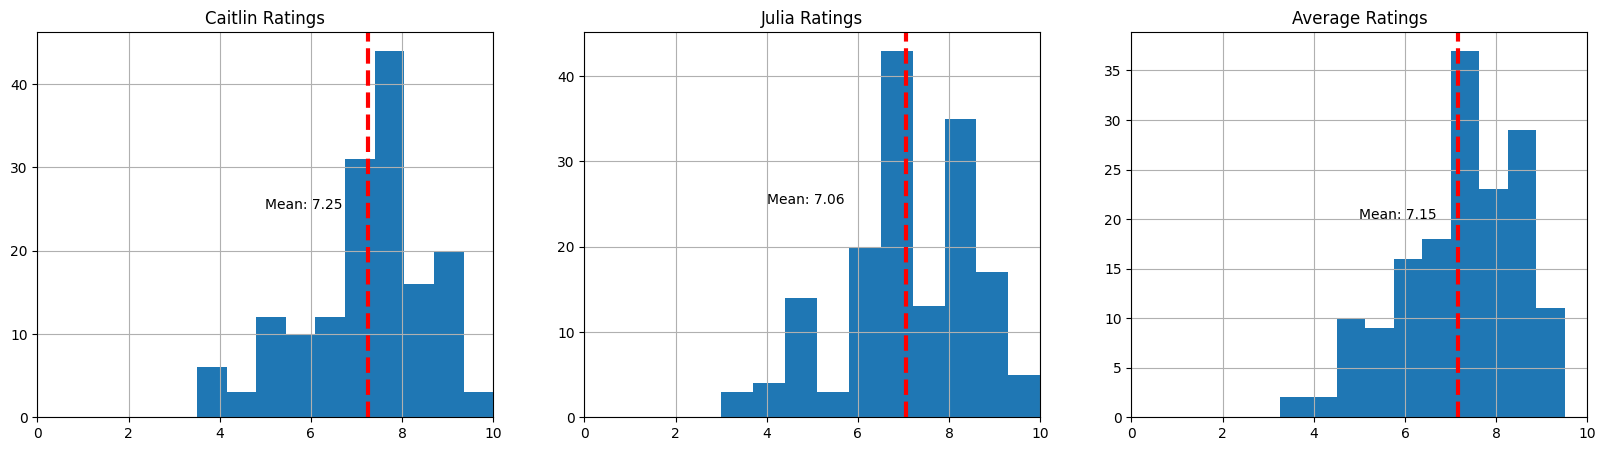

In [ ]:
watched = doc.get_worksheet(1)
watch_history = watched.get_all_values()
mov = pd.DataFrame.from_records(watch_history)
mov = mov.iloc[1:]

# any blanks coerce to NaN, replace NaN with that column's average for the purposes of graphing
mov[2] = pd.to_numeric(mov[2], errors='coerce')
mov[3] = pd.to_numeric(mov[3], errors='coerce')
mov[4] = pd.to_numeric(mov[4], errors='coerce')
mov[2] = mov[2].fillna(mov[2].mean())
mov[3] = mov[3].fillna(mov[3].mean())
mov[4] = mov[4].fillna(mov[4].mean())

cc_ratings = mov[2].astype(float)
jm_ratings = mov[3].astype(float)
avg_ratings = mov[4].astype(float)

fig, axes = plt.subplots(1, 3, figsize = (20,5))
cc_ratings.hist(ax = axes[0])
jm_ratings.hist(ax = axes[1])
avg_ratings.hist(ax = axes[2])

axes[0].axvline(x=np.nanmean(cc_ratings), color='red', linestyle='--', linewidth=3, label='Avg')
axes[1].axvline(x=np.nanmean(jm_ratings), color='red', linestyle='--', linewidth=3, label='Avg')
axes[2].axvline(x=np.nanmean(avg_ratings), color='red', linestyle='--', linewidth=3, label='Avg')
axes[0].text(5, 25, 'Mean: {:.2f}'.format(np.nanmean(cc_ratings)))
axes[1].text(4, 25, 'Mean: {:.2f}'.format(np.nanmean(jm_ratings)))
axes[2].text(5, 20, 'Mean: {:.2f}'.format(np.nanmean(avg_ratings)))

axes[0].title.set_text('Caitlin Ratings')
axes[1].title.set_text('Julia Ratings')
axes[2].title.set_text('Average Ratings')

axes[0].set_xlim([0, 10])
axes[1].set_xlim([0, 10])
axes[2].set_xlim([0, 10])

In [ ]:
import numpy as np
runtimes = pd.DataFrame(mov[8])
runtimes.head()
new = runtimes[8].str.split('h', n=1, expand=True)
hour = new[0]
min = new[1].str.split('m', n=1, expand=True)[0]
runtimes['minutes'] = hour.astype(int)*60 + min.astype(int)
tot_min = sum(runtimes['minutes'])
tot_hr = np.floor(sum(runtimes['minutes']) / 60 )
tot_day = tot_min / (60*24)
print("We've seen " + str(tot_min) + " minutes of movies together, which is " + str(tot_hr) + " hours and " + str(sum(runtimes['minutes'])%60) + " minutes or " + str(tot_day) + " days")

We've seen 17669 minutes of movies together, which is 294.0 hours and 29 minutes or 12.270138888888889 days


In [ ]:
from typing import AbstractSet
actors = mov[12]
actors = actors.str.split("/")

counts = {}
for acts in actors:
  if acts == []:
    pass
  else:
    for actor1 in acts:
      if actor1 in counts.keys():
        counts[actor1] = counts[actor1] + 1
      else:
        counts[actor1] = 1

del counts['']
dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

{'Anne Hathaway': 6,
 'Jennifer Lawrence': 5,
 'Ryan Gosling': 5,
 'Zendaya': 4,
 'Kate Hudson': 4,
 'Florence Pugh': 4,
 'Sarah Michelle Gellar': 4,
 'James Marsden': 3,
 'Emma Stone': 3,
 'Aubrey Plaza': 3,
 'Jamie Lee Curtis': 3,
 'Andrew Garfield': 2,
 'Sandra Bullock': 2,
 'Maya Hawke': 2,
 'Bradley Cooper': 2,
 'Margot Robbie': 2,
 'Sam Claflin': 2,
 'Taylor Swift': 2,
 'Leonardo DiCaprio': 2,
 'Kristen Stewart': 2,
 'Taylor Lautner': 2,
 'Nicholas Galitzine': 2,
 'Natasha Lyonne': 2,
 'Daisy Edgar-Jones': 2,
 'Dakota Johnson': 2,
 'Elisabeth Moss': 1,
 'Matt Damon': 1,
 'Alison Brie': 1,
 'Renee Rapp': 1,
 'Meryl Streep': 1,
 'Winona Ryder': 1,
 'Kristen Bell': 1,
 'Andy Samberg': 1,
 'Timothee Chalamet': 1,
 'Kiera Knightley': 1,
 'Eddie Murphy': 1,
 'Ke Huy Quan': 1}

## ML Experimentation

In [ ]:
mov_x = mov[[5,6,7,10,11,14,15]].copy() # grab meaninful features
mov_x[1] = runtimes["minutes"] # add runtime in # of mins

mov_x.columns = ['Genre1', 'Genre2', 'Year','RT','IMDb','GFCC','GenreCluster','Min']
mov_x['Year'] = pd.to_numeric(mov_x['Year'])
mov_x['RT'] = mov_x['RT'].str.rstrip('%').astype('float') / 100.0
mov_x['IMDb'] = pd.to_numeric(mov_x['IMDb'])

caitlin_y = mov[[2]]
julia_y = mov[[3]]
both_y = mov[[4]]
mov_x.shape

(157, 8)

In [ ]:
genre_cat = mov_x[['Genre1','Genre2']].stack().str.get_dummies().groupby(level=0).sum()
gfcc_cat = pd.get_dummies(mov_x[['GFCC']])
genre_cluster_cat = pd.get_dummies(mov_x[['GenreCluster']])
genre_cluster_cat.shape

(157, 6)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(mov_x[['Year','RT','IMDb','Min']])
num_x = pd.DataFrame(scaler.transform(mov_x[['Year','RT','IMDb','Min']]), columns=['Year','RT','IMDb','Min'])
num_x.head()

,Year,RT,IMDb,Min
0,0.726027,0.431579,0.641509,0.533333
1,0.630137,0.810526,0.716981,0.171429
2,0.958904,0.926316,0.886792,0.695238
3,0.767123,0.326316,0.566038,0.466667
4,0.986301,0.957895,0.981132,0.619048


In [ ]:
genre_cat.reset_index(drop=True, inplace=True)
num_x.reset_index(drop=True, inplace=True)
gfcc_cat.reset_index(drop=True, inplace=True)
genre_cluster_cat.reset_index(drop=True, inplace=True)
mov_x_all = pd.concat([genre_cat, num_x, gfcc_cat, genre_cluster_cat], axis=1)
mov_x_all = mov_x_all.dropna()
mov_x_all.shape


(157, 40)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

x_train, x_test, y_train, y_test = train_test_split(mov_x_all,both_y,test_size=.2)
rf = RandomForestRegressor()
rf.fit(x_train, np.array(y_train))
predicted = rf.predict(x_test)
mean_squared_error(y_test, predicted)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


1.7509972656250001

In [ ]:
x_test.head()

,Action,Adventure,Comedy,Crime,Drama,Familiy,Family,Fantasy,Horror,Indie Film,...,GFCC_Old,GFCC_Period Piece,GFCC_Superhero,GFCC_Teenage Girl,GenreCluster_Action,GenreCluster_Animated,GenreCluster_Comedy,GenreCluster_Drama,GenreCluster_Horror,GenreCluster_Mystery
115,0,0,1,0,0,0,1,0,0,0,...,False,False,False,False,False,True,False,False,False,False
140,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False
41,0,0,0,0,0,0,1,1,0,0,...,False,False,False,False,False,True,False,False,False,False
86,0,0,0,1,0,0,0,0,0,0,...,False,False,False,True,False,False,False,False,False,True
31,0,0,0,1,1,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False


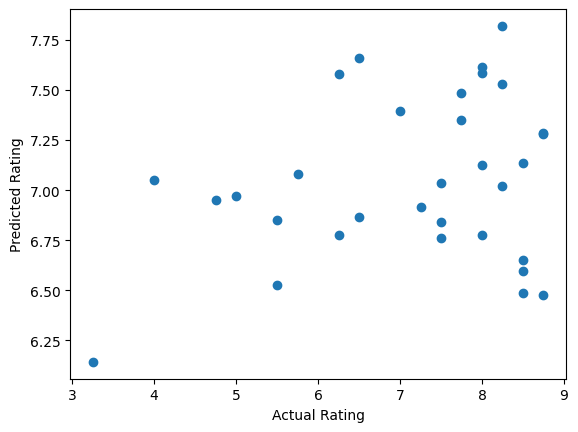

In [ ]:
plt.scatter(y_test, predicted)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.show()